<a href="https://colab.research.google.com/github/midokorg/Gat-Vit/blob/main/ViT_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# GNN uniquement à partir de herg_graphs.pt avec labels intégrés
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 59.5 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.0 MB/s eta 0:00:00


PermutationExplainer explainer: 263it [00:12,  6.25it/s]                         
<ipython-input-9-27ec7cf36d6f>:33: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_mean, X_clinical, feature_names=clinical_cols, show=True)


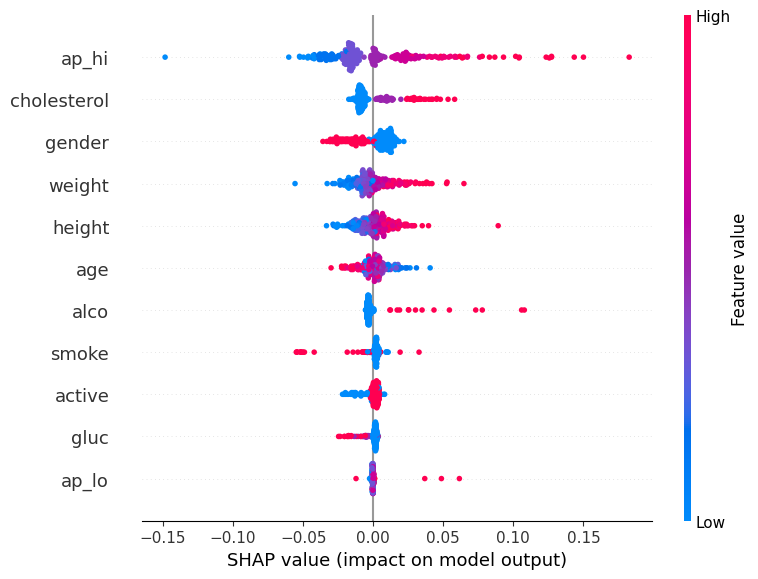

In [ ]:
import shap
import numpy as np
import torch

# Define prediction function
def predict_fn(X):
    X = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        return model.fc_clinical(X).cpu().numpy()

# Prepare data
X_clinical = []
y_true = []
for batch in test_loader:
    X_clinical.extend(batch['clinical'].cpu().numpy())
    y_true.extend(batch['label'].numpy())
X_clinical = np.array(X_clinical)

# Define clinical column names
clinical_cols = ['age','gender','height','weight','ap_hi','ap_lo','cholesterol','gluc','smoke','alco','active']

# SHAP Explainer
explainer = shap.Explainer(predict_fn, X_clinical[:100])
shap_values = explainer(X_clinical)

# Access the values attribute of the Explanation object
shap_values_array = shap_values.values

# Average SHAP values across the extra dimension (axis 2)
shap_values_mean = np.mean(shap_values_array, axis=2)

# Summary plot without class labels
shap.summary_plot(shap_values_mean, X_clinical, feature_names=clinical_cols, show=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 001 - Train Loss: 0.6351 - Val Loss: 0.5616 - AUC: 0.8153 - Acc: 0.7443 - Thresh: 0.50
Epoch 002 - Train Loss: 0.5319 - Val Loss: 0.4049 - AUC: 0.9093 - Acc: 0.8511 - Thresh: 0.56
Epoch 003 - Train Loss: 0.4139 - Val Loss: 0.3251 - AUC: 0.9295 - Acc: 0.8626 - Thresh: 0.48
Epoch 004 - Train Loss: 0.3729 - Val Loss: 0.3357 - AUC: 0.9385 - Acc: 0.8817 - Thresh: 0.61
Epoch 005 - Train Loss: 0.3785 - Val Loss: 0.3343 - AUC: 0.9270 - Acc: 0.8779 - Thresh: 0.36
Epoch 006 - Train Loss: 0.3490 - Val Loss: 0.2723 - AUC: 0.9479 - Acc: 0.9046 - Thresh: 0.39
Epoch 007 - Train Loss: 0.3106 - Val Loss: 0.2433 - AUC: 0.9539 - Acc: 0.9160 - Thresh: 0.54
Epoch 008 - Train Loss: 0.2997 - Val Loss: 0.3370 - AUC: 0.9567 - Acc: 0.9122 - Thresh: 0.93
Epoch 009 - Train Loss: 0.2876 - Val Loss: 0.2663 - AUC: 0.9514 - Acc: 0.9084 - Thresh: 0.23
Epoch 010 - Train Loss: 0.2643 - Val Loss: 0.1931 - AUC: 0.9715 - Acc: 0.9313 - Thresh: 0.43
Epoch 011 - Train Loss: 0.2497 - Val Loss: 0.2024 - AUC: 0.9719 - Acc:

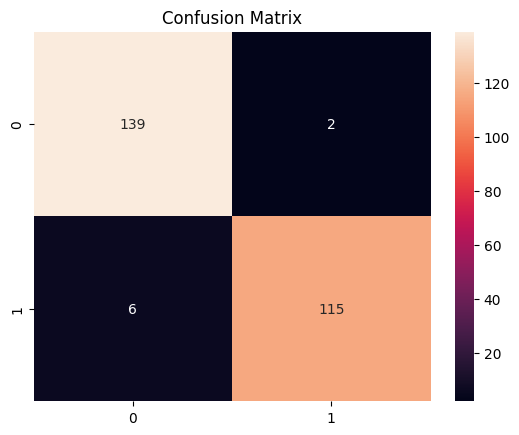

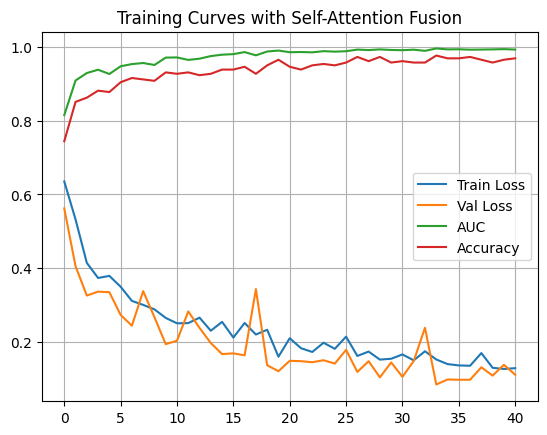

In [ ]:
# ========= CELLULE 1 : Imports, Dataset, Preprocessing ========= #
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.models import vit_b_16
from torch_geometric.data import Batch
from torch_geometric.nn import GATConv, global_mean_pool
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

# === Dataset multimodal avec normalisation ===
class MultimodalDataset(Dataset):
    def __init__(self, graph_path, clinical_path, ecg_root):
        self.graphs = torch.load(graph_path, weights_only=False)
        self.graph_dict = {g.chembl_id: g for g in self.graphs}
        self.df = pd.read_csv(clinical_path, sep=';')
        self.ecg_root = ecg_root
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        self.df = self.df[self.df['molecule_chembl_id'].isin(self.graph_dict.keys())]
        self.df['ecg_path'] = self.df.apply(lambda row: os.path.join(
            ecg_root,
            'CLASS1' if row['cardio'] == 1 else 'CLASS0',
            row['ecg_file'].strip() + ".jpg"
        ), axis=1)

        self.clinical_cols = ['age','gender','height','weight','ap_hi','ap_lo','cholesterol','gluc','smoke','alco','active']
        scaler = StandardScaler()
        self.df[self.clinical_cols] = scaler.fit_transform(self.df[self.clinical_cols])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        graph = self.graph_dict[row['molecule_chembl_id']]
        ecg_img = Image.open(row['ecg_path']).convert("RGB")
        ecg_tensor = self.transform(ecg_img)
        clinical = torch.tensor(row[self.clinical_cols].values.astype(np.float32))
        label = torch.tensor(row['cardio'], dtype=torch.float32)
        return {'graph': graph, 'ecg': ecg_tensor, 'clinical': clinical, 'label': label}

# ========= CELLULE 2 : Fusion Self Attention + Modèle ========= #
class FusionSelfAttention(nn.Module):
    def __init__(self, embed_dim=128, num_modalities=3, num_heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)
        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_modalities * embed_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x1, x2, x3):
        x = torch.stack([x1, x2, x3], dim=1)  # [B, 3, 128]
        attn_out, _ = self.attn(x, x, x)
        attn_out = self.norm(attn_out)
        return self.output(attn_out)

class FusionModelViT(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=128, clinical_dim=11):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_dim, heads=4, dropout=0.2)
        self.gat2 = GATConv(hidden_dim * 4, hidden_dim, heads=1, concat=False, dropout=0.2)
        self.norm_gnn = nn.LayerNorm(hidden_dim)

        self.vit = vit_b_16(pretrained=True)
        for param in self.vit.parameters():
            param.requires_grad = False
        for name, param in self.vit.named_parameters():
            if 'blocks.10' in name or 'blocks.11' in name or 'norm' in name:
                param.requires_grad = True
        self.vit.heads = nn.Identity()

        self.fc_ecg = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128)
        )
        self.norm_ecg = nn.LayerNorm(128)

        self.fc_clinical = nn.Sequential(
            nn.Linear(clinical_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 128)
        )
        self.norm_fusion = nn.LayerNorm(384)

        self.fusion_attention = FusionSelfAttention(embed_dim=128, num_modalities=3, num_heads=4)

    def forward(self, graph, ecg, clinical):
        x, edge_index, batch = graph.x, graph.edge_index, graph.batch
        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.norm_gnn(x)

        e = self.vit(ecg)
        e = self.fc_ecg(e)
        e = self.norm_ecg(e)

        c = self.fc_clinical(clinical)
        return self.fusion_attention(x, e, c).squeeze(1)

# ========= CELLULE 3 : Collate, DataLoader, Training ========= #
def multimodal_collate(batch):
    graphs = [item['graph'] for item in batch]
    return {
        'graph': Batch.from_data_list(graphs),
        'ecg': torch.stack([item['ecg'] for item in batch]),
        'clinical': torch.stack([item['clinical'] for item in batch]),
        'label': torch.stack([item['label'] for item in batch])
    }

graph_path = "/content/drive/MyDrive/colab/DATASET_HERG_BAL/herg_graphs.pt"
clinical_path = "/content/drive/MyDrive/colab/DATASET_HERG_BAL/cardio_train.csv"
ecg_root = "/content/drive/MyDrive/colab/DATASET_HERG_BAL"

dataset = MultimodalDataset(graph_path, clinical_path, ecg_root)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=multimodal_collate)
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=multimodal_collate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FusionModelViT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

# ========= CELLULE 4 : Entrainement avec Early Stopping ========= #
train_losses, val_losses, val_aucs, accuracies = [], [], [], []
best_val_loss = float('inf')
epochs_no_improve = 0
patience = 7

for epoch in range(1, 51):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch['graph'].to(device), batch['ecg'].to(device), batch['clinical'].to(device))
        loss = criterion(out, batch['label'].to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    model.eval()
    val_loss, preds, labels = 0, [], []
    with torch.no_grad():
        for batch in test_loader:
            out = model(batch['graph'].to(device), batch['ecg'].to(device), batch['clinical'].to(device))
            val_batch_loss = criterion(out, batch['label'].to(device))
            val_loss += val_batch_loss.item()
            preds.extend(torch.sigmoid(out).cpu().numpy())
            labels.extend(batch['label'].cpu().numpy())
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    precision, recall, thresholds = precision_recall_curve(labels, preds)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
    best_thresh = thresholds[np.argmax(f1_scores)]
    bin_preds = [1 if p >= best_thresh else 0 for p in preds]
    auc = roc_auc_score(labels, preds)
    acc = accuracy_score(labels, bin_preds)
    val_aucs.append(auc)
    accuracies.append(acc)

    print(f"Epoch {epoch:03d} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_loss:.4f} - AUC: {auc:.4f} - Acc: {acc:.4f} - Thresh: {best_thresh:.2f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch}")
            break

# ========= CELLULE 5 : Evaluation Finale ========= #
print("\n=== Final Evaluation Report ===")
print(classification_report(labels, bin_preds))
sns.heatmap(confusion_matrix(labels, bin_preds), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(val_aucs, label="AUC")
plt.plot(accuracies, label="Accuracy")
plt.legend(); plt.grid(); plt.title("Training Curves with Self-Attention Fusion")
plt.show()


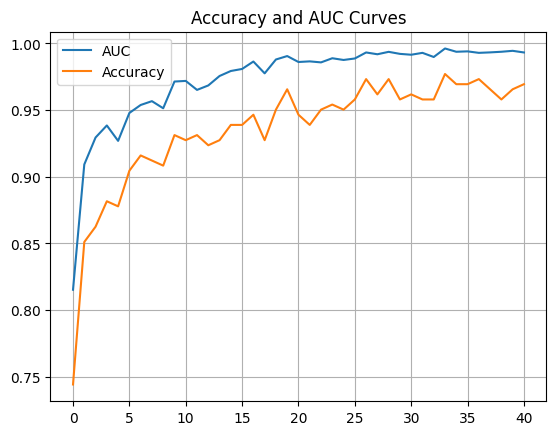

In [ ]:

plt.plot(val_aucs, label="AUC")
plt.plot(accuracies, label="Accuracy")
plt.legend(); plt.grid(); plt.title("Accuracy and AUC Curves")
plt.show()

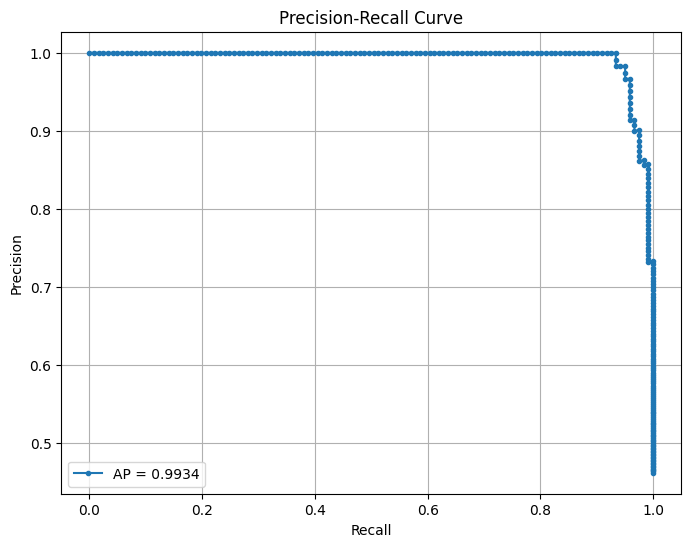

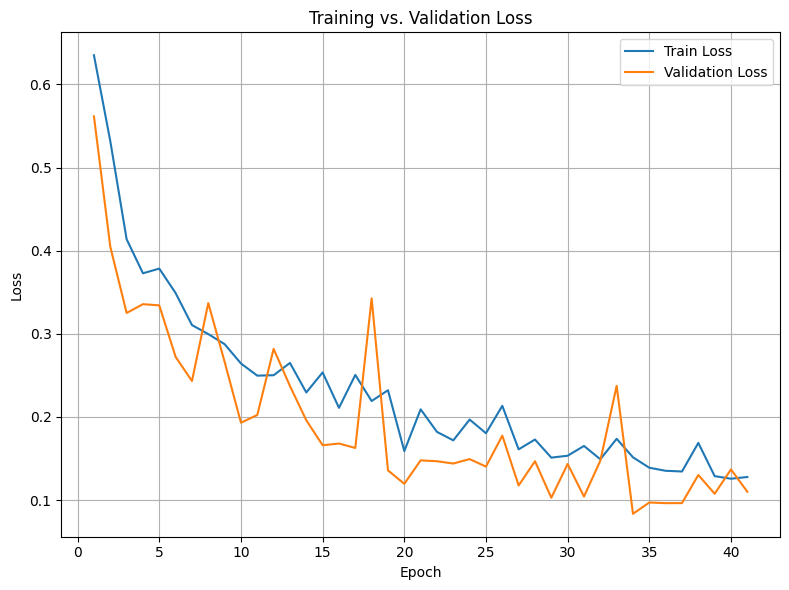

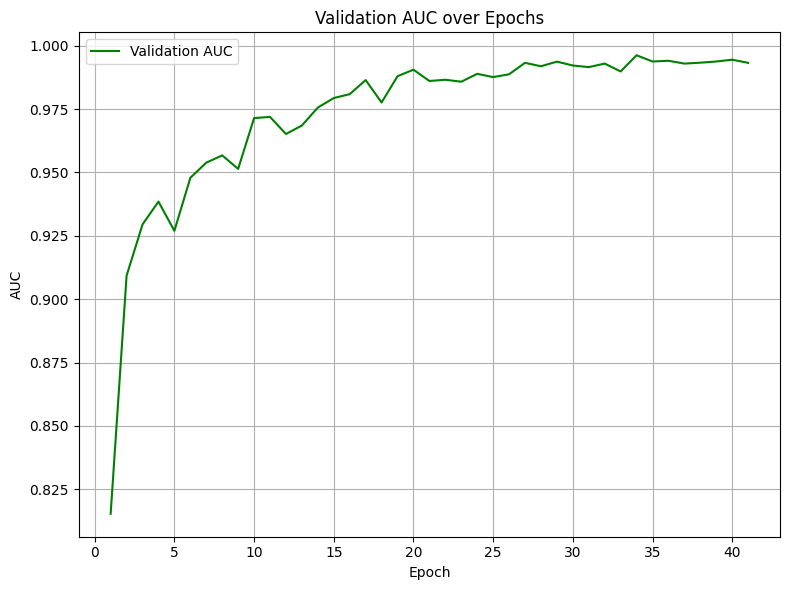

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Supposons que `preds` et `labels` sont déjà disponibles après l'évaluation
# `preds` : liste des probabilités (sortie de sigmoid)
# `labels`: liste des vrais labels binaires

# Calcul de la courbe précision-rappel
precision, recall, thresholds = precision_recall_curve(labels, preds)
ap = average_precision_score(labels, preds)

# Affichage
plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label=f'AP = {ap:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()


# train_losses, val_losses, val_aucs sont déjà collectés pendant l'entraînement

epochs = range(1, len(train_losses) + 1)

# --- Courbe des pertes ---
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Courbe des AUC ---
plt.figure(figsize=(8, 6))
plt.plot(epochs, val_aucs, label='Validation AUC', color='green')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation AUC over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




=== Full Evaluation Metrics ===
Accuracy           : 0.9695
Precision          : 0.9829
Recall             : 0.9504
F1-score           : 0.9664
ROC AUC            : 0.9933
MCC                : 0.9389
Balanced Accuracy  : 0.9681
Cohen's Kappa      : 0.9384

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       141
         1.0       0.98      0.95      0.97       121

    accuracy                           0.97       262
   macro avg       0.97      0.97      0.97       262
weighted avg       0.97      0.97      0.97       262



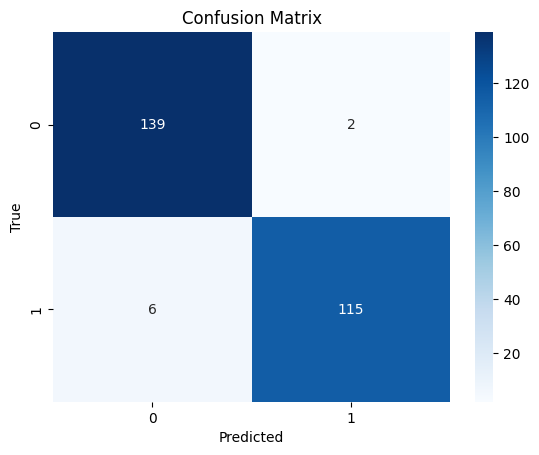

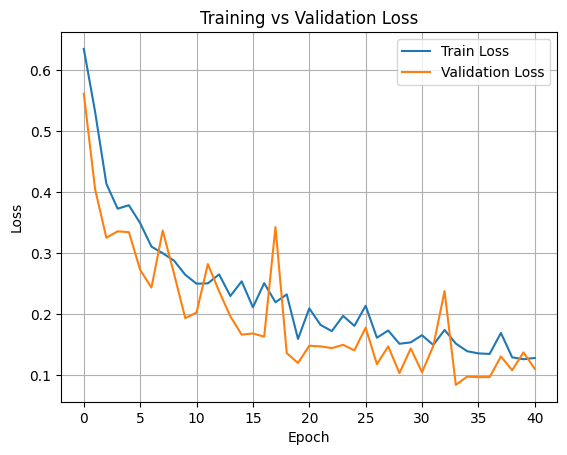

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, balanced_accuracy_score,
    cohen_kappa_score, classification_report, confusion_matrix
)

# --- Calcul des métriques ---
accuracy = accuracy_score(labels, bin_preds)
precision = precision_score(labels, bin_preds)
recall = recall_score(labels, bin_preds)
f1 = f1_score(labels, bin_preds)
auc = roc_auc_score(labels, preds)
mcc = matthews_corrcoef(labels, bin_preds)
balanced_acc = balanced_accuracy_score(labels, bin_preds)
kappa = cohen_kappa_score(labels, bin_preds)

# --- Affichage formaté ---
print("\n=== Full Evaluation Metrics ===")
print(f"Accuracy           : {accuracy:.4f}")
print(f"Precision          : {precision:.4f}")
print(f"Recall             : {recall:.4f}")
print(f"F1-score           : {f1:.4f}")
print(f"ROC AUC            : {auc:.4f}")
print(f"MCC                : {mcc:.4f}")
print(f"Balanced Accuracy  : {balanced_acc:.4f}")
print(f"Cohen's Kappa      : {kappa:.4f}")


# --- Rapport et matrice de confusion ---
print("\nClassification Report:")
print(classification_report(labels, bin_preds))

import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(confusion_matrix(labels, bin_preds), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

